In [1]:
from federated_learning.dataloader import FashionMNISTDataloader
from federated_learning.configuration import Configuration
import torch 


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Configuration 

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
device = torch.device('cpu')
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
config = Configuration()
mnist = FashionMNISTDataloader(config)
examples = enumerate(mnist.test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


FashionMnist training loader loaded.
FashionMnist training loader loaded.


torch.Size([1000, 1, 28, 28])

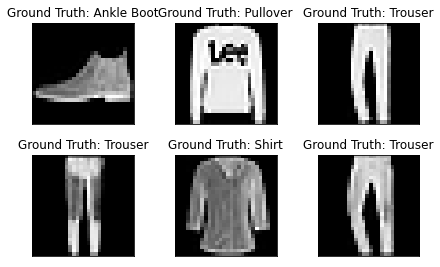

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(mnist.labels[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])

# Train Model

## Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class FashionMNISTCNN(nn.Module):

    def __init__(self):
        super(FashionMNISTCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x


In [8]:
network = FashionMNISTCNN()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(mnist.train_dataloader.dataset) for i in range(n_epochs)]

In [36]:
# Train and Test Funktions
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(mnist.train_dataloader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(mnist.train_dataloader.dataset),100. * batch_idx / len(mnist.train_dataloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(mnist.train_dataloader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in mnist.test_dataloader:
            output = network(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            print(loss.item())
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += 1
    print(test_loss, total,len(mnist.test_dataloader.dataset), test_loss/total)
    test_loss /= total
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(mnist.test_dataloader.dataset), 100. * correct / len(mnist.test_dataloader.dataset)))

In [11]:
len(mnist.train_dataloader.dataset)

60000

In [12]:
len(mnist.test_dataloader.dataset)

10000

In [37]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

0.28769955039024353
0.30146971344947815
0.34227338433265686
0.39013025164604187
0.3014158606529236
0.321542888879776
0.276479035615921
0.2205609232187271
0.27816733717918396
0.24973714351654053
2.9694760888814926 10 10000 0.29694760888814925

Test set: Avg. loss: 0.2969, Accuracy: 9072/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.094516
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.120389
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.058571
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.072944
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.057597
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.112147
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.104515
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.072042
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.115612
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.069659
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.141874
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.062940
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.187389
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.077745
Train Epoch: 1 [8960/60000 